# KAIST AI605 Assignment 2: Word Embeddings

## Rubric

### Deadline 
The deadline for this assignment is: Friday 21st October 2022 (Week 8) 11:59pm

### Submission
Please submit your assignment via [KLMS](https://klms.kaist.ac.kr). You must submit both (1) a PDF of your solutions and (2) the Jupyter Notebook file (.ipynb).

Use in-line LaTeX for mathematical expressions. 

### Collaboration
This assignment is not a group assignment so make sure your answer and code are your own.

### Grading
The total number of marks avaiable is 30 points.

### Environment
The use of a GPU is not required for this notebook. The required environment for this is Python 3.9. Run the following cell to set up the environment.

In [1]:
!python --version

Python 3.8.6rc1


In [2]:
# pip install torch nltk scikit-learn tqdm

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Problem 1: Text Pre-processing (6 points)

This question will use a sample of data from Wikipedia to generate the instances for constructing word embeddings. Recall that in the lecture, we considered two methods for generating word embeddings: matrix factorization and Word2vec. For both cases, we need to know which words appear in the context of a given word. 

When generating our data for building word embeddings, we need to preprocess the raw text to extract the words appearing in the context around a word. 

For simplicity, this question will only consider contexts from the middle of the sentence, ignoring the start and end tokens. 

* For tokens: $w_1, w_2, w_3, w_4, w_5, w_6, w_7$

* $\text{context}(w_2,1) = (w_1,w_3)$
* $\text{context}(w_4,2) = (w_2,w_3,w_5,w_6)$
* $\text{context}(w_1,1) = Undefined$


Data will come from the file `wiki.sample.jsonl` which contains a sample of 50000 wikipedia pages. We can load the data with the following block

In [4]:
import json

def load_data(filename):
    with open(filename) as f:
        for line in f:
            try:
                yield json.loads(line)
            except Exception as e:
                print(line)
                raise e

all_data = list(load_data("wiki.sample.jsonl"))

Each item in `all_data` is a dictionary consisting of a page from Wikipedia and its sentences. We can get its text from the `text` entry in this dictionary. The text is pre-tokenized so we can split by whitepace to get a list of tokens.

In [5]:
from itertools import islice

# Print the first item
print(all_data[0])

def get_tokens(page):
    return page['text'].split()
    
print()
        
# Print the text of the first 10 sentences
for page in islice(all_data,10):
    print(get_tokens(page))
    print()

{'id': 'Christodoulos_Christodoulides', 'text': 'Christodoulos Christodoulides -LRB- born August 22 , 1976 -RRB- is a Cypriot judoka who won the silver medal at the 2002 Commonwealth Games . At the final he was defeated by the Australian Tom Hill He also represented Cyprus at the 2004 Summer Olympics for 73 kg but was eliminated by the Portuguese João Neto in the First Round . In his career , he won also three gold medals for Cyprus in the  Games of the Small States of Europe ; in 1999 , 2001 and 2003 . ', 'lines': "0\tChristodoulos Christodoulides -LRB- born August 22 , 1976 -RRB- is a Cypriot judoka who won the silver medal at the 2002 Commonwealth Games .\tCypriot\tCyprus\t2002 Commonwealth Games\t2002 Commonwealth Games\n1\tAt the final he was defeated by the Australian Tom Hill He also represented Cyprus at the 2004 Summer Olympics for 73 kg but was eliminated by the Portuguese João Neto in the First Round .\tCyprus at the 2004 Summer Olympics for 73 kg\tJudo at the 2004 Summer Ol

**Problem 1.1** (3 points) Implement the context function that returns the surrounding context for a given instance. Add these to a list of instances called `all_instances` where each instance is the word and context `[(word3, [word1,word2,word4,word5]), (word4, [word2,word3,word5,word6]), ...]`

The data should look like this for the first sentence and a context size of $\pm 2$: 

```
are ['The', 'following', 'the', 'football']
the ['following', 'are', 'football', '-LRB-']
football ['are', 'the', '-LRB-', 'soccer']
-LRB- ['the', 'football', 'soccer', '-RRB-']
soccer ['football', '-LRB-', '-RRB-', 'events']
-RRB- ['-LRB-', 'soccer', 'events', 'of']
events ['soccer', '-RRB-', 'of', 'the']
of ['-RRB-', 'events', 'the', 'year']
the ['events', 'of', 'year', '1928']
year ['of', 'the', '1928', 'throughout']
1928 ['the', 'year', 'throughout', 'the']
throughout ['year', '1928', 'the', 'world']
the ['1928', 'throughout', 'world', '.']
```

Implement this function for a context_size of 10 and generate training instances from all pages in the dataset 

In [6]:
from tqdm.notebook import tqdm

def make_instances(tokens, context_size=2):
    content_list = []
    for i, token in enumerate(tokens[context_size:(len(tokens)-context_size)]): 
        content_list.append((tokens[context_size+i],tokens[i:(i+context_size)]+tokens[(context_size+i+1):(context_size+i+context_size+1)]))
    return content_list
    
# Add context to a list of all_instances with a context radius of 
# +/- 10 tokens
all_instances = []
for page in tqdm(all_data):
    tokens = get_tokens(page)
    instances = make_instances(tokens,10)
    all_instances.extend(instances)
    
# You should generate approximately 3.7M instances
print(len(all_instances))
    
# Print a sample of the first 20
for word, context in islice(all_instances,20):
    print(word, context)
    print('\n')

  0%|          | 0/50000 [00:00<?, ?it/s]

3780225
a ['Christodoulos', 'Christodoulides', '-LRB-', 'born', 'August', '22', ',', '1976', '-RRB-', 'is', 'Cypriot', 'judoka', 'who', 'won', 'the', 'silver', 'medal', 'at', 'the', '2002']


Cypriot ['Christodoulides', '-LRB-', 'born', 'August', '22', ',', '1976', '-RRB-', 'is', 'a', 'judoka', 'who', 'won', 'the', 'silver', 'medal', 'at', 'the', '2002', 'Commonwealth']


judoka ['-LRB-', 'born', 'August', '22', ',', '1976', '-RRB-', 'is', 'a', 'Cypriot', 'who', 'won', 'the', 'silver', 'medal', 'at', 'the', '2002', 'Commonwealth', 'Games']


who ['born', 'August', '22', ',', '1976', '-RRB-', 'is', 'a', 'Cypriot', 'judoka', 'won', 'the', 'silver', 'medal', 'at', 'the', '2002', 'Commonwealth', 'Games', '.']


won ['August', '22', ',', '1976', '-RRB-', 'is', 'a', 'Cypriot', 'judoka', 'who', 'the', 'silver', 'medal', 'at', 'the', '2002', 'Commonwealth', 'Games', '.', 'At']


the ['22', ',', '1976', '-RRB-', 'is', 'a', 'Cypriot', 'judoka', 'who', 'won', 'silver', 'medal', 'at', 'the', '2002

**Problem 1.2** (1 point) How many unique tokens were observed? How many tokens were observed at least 50 times?


In [7]:
import numpy as np #count it twice for word only and for context too 

In [8]:
print(f'Total number of unique tokens: {len(np.unique([word for word, context in all_instances]))}') #this is taking way longer 

Total number of unique tokens: 180684


In [9]:
from collections import Counter
tokens_counted = Counter([word for word, context in all_instances]) #take into accout the context wrods!!! double loop 

In [10]:
print(f'Total number of unique tokens: {len(list(tokens_counted))}') #checking correctes of abow and fastest way 

Total number of unique tokens: 180684


In [11]:
tokens_counted.most_common(10) #out of curiosity

[(',', 210973),
 ('the', 203903),
 ('.', 146994),
 ('of', 121745),
 ('and', 101498),
 ('in', 97803),
 ('a', 66808),
 ('to', 53127),
 ('was', 48848),
 ('-RRB-', 40293)]

In [12]:
freq_50 = np.array(list(tokens_counted.items()))[np.array(list(tokens_counted.values()))>50]
print(f'Number of tokens at least frequent 50 times: {len(freq_50)}')

Number of tokens at least frequent 50 times: 6113


**Problem 1.3** (1 point) for simplicity, we will only use the 10,000 most-frequent tokens. Make a *vocab* dictionary of the top 10,000 tokens that contains a mapping of word to ID. Make sure to include an entry for the unknown token (10001 tokens in total)

e.g. `{"the":0, "a":1, ..., "magic":100, "Korea": 101, ...,  "testing": 9999, "[UNK]":10000}` 

Use this vocabulary of 10,001 tokens, create a new list of instances `processed_instances` that replaces tokens in `all_instances` that do not appear in the *vocab* with a special placeholder token *[UNK]*



In [13]:
placeholder ="<UNK>"
almost_vocab = tokens_counted.most_common(10000) 

In [14]:
vocab = {}
for i, (token, count) in enumerate(almost_vocab):
    vocab[token] = i
vocab[placeholder] = i + 1

In [15]:
len(vocab) # Should be 10000 + 1 for the placeholder (10001 in total)

10001

In [16]:
processed_instances = []
for instance in all_instances:
    token, content = instance
    if(token in vocab.keys()):
        pass
    else:
        token = "<UNK>"
        
    if(all(content) in vocab.keys()):
        pass
    else:
        for i, element in enumerate(content):
            if(element not in vocab.keys()):
                content[i] = "<UNK>"
    processed_instances.append((token,content)) 

In [17]:
len(processed_instances)

3780225

In [18]:
# Print a sample of the first 10
for word, context in islice(processed_instances,10):
    print(word, context)

a ['<UNK>', '<UNK>', '-LRB-', 'born', 'August', '22', ',', '1976', '-RRB-', 'is', '<UNK>', 'judoka', 'who', 'won', 'the', 'silver', 'medal', 'at', 'the', '2002']
<UNK> ['<UNK>', '-LRB-', 'born', 'August', '22', ',', '1976', '-RRB-', 'is', 'a', 'judoka', 'who', 'won', 'the', 'silver', 'medal', 'at', 'the', '2002', 'Commonwealth']
judoka ['-LRB-', 'born', 'August', '22', ',', '1976', '-RRB-', 'is', 'a', '<UNK>', 'who', 'won', 'the', 'silver', 'medal', 'at', 'the', '2002', 'Commonwealth', 'Games']
who ['born', 'August', '22', ',', '1976', '-RRB-', 'is', 'a', '<UNK>', 'judoka', 'won', 'the', 'silver', 'medal', 'at', 'the', '2002', 'Commonwealth', 'Games', '.']
won ['August', '22', ',', '1976', '-RRB-', 'is', 'a', '<UNK>', 'judoka', 'who', 'the', 'silver', 'medal', 'at', 'the', '2002', 'Commonwealth', 'Games', '.', 'At']
the ['22', ',', '1976', '-RRB-', 'is', 'a', '<UNK>', 'judoka', 'who', 'won', 'silver', 'medal', 'at', 'the', '2002', 'Commonwealth', 'Games', '.', 'At', 'the']
silver [',',

**Problem 1.4** (1 point) If we do not restrict the size of the vocabulary, we may encounter millions of unique tokens during training. What negative consequences can this have for the models used to generate word embeddings? 

The training would be taking to long because of the factorization and storage of $n x n$ matrix. But also we will have to many tokens with the same content which will be confusing and training of network would be hard. There would be no visible connection between words. We want to extract sometinhg from sentence and minimilize our vocabulary so network would know only the important tokens. 

## Problem 2: Matrix Factorization for Word Embeddings (6 points)

We can construct a matrix of cooccurrence counts by iterating over all data and adding items to a 10001x10001 matrix (10,000 tokens + 1 placeholder tokens). 

(the code will take approximatly 3 minutes to run)

In [19]:
import torch
words_contexts = torch.zeros((len(vocab),len(vocab)))

for word, context_tokens in tqdm(processed_instances):
    words_contexts[vocab[word]][[vocab[c] for c in context_tokens]] += 1

  0%|          | 0/3780225 [00:00<?, ?it/s]

**Problem 2.1** (3 points) Using this matrix of word-context counts, compute the matrix of positively shifted pointwise mutual information for each pair of words $(x,y)\in \text{Vocab}^2$. 

$$PSPMI(x,y) = \log (1 + \frac{p(x,y)}{p(x)p(y)})$$

Note: inefficient solutions that take significantly more than 1 minute to run will receive zero score.

Quick solution: 

In [35]:
import numpy as np
tokens_counted = Counter([word for word, context in processed_instances])

In [36]:
p_xy = words_contexts/sum(words_contexts, -1)
y_counts = np.repeat(np.array(list(tokens_counted.values()))/len(vocab), len(vocab))
y_counts = y_counts.reshape(len(vocab),len(np.array(list(tokens_counted.values()))))


In [43]:
positively_shifted  = np.log(1 + (p_xy/(y_counts@y_counts.T)))

In [44]:
positively_shifted

tensor([[1.2774e-07, 1.5361e-08, 2.2362e-04,  ..., 5.2061e-04, 1.6209e-04,
         3.0434e-04],
        [1.6314e-08, 2.4164e-09, 3.8742e-05,  ..., 2.1536e-05, 1.9287e-05,
         4.0148e-05],
        [1.6627e-04, 2.7785e-05, 9.3560e-02,  ..., 2.0787e-01, 1.9473e-01,
         3.7314e-01],
        ...,
        [5.5598e-08, 3.3985e-09, 3.3808e-05,  ..., 2.6481e-01, 0.0000e+00,
         9.5115e-05],
        [2.2058e-08, 2.2131e-09, 3.7258e-05,  ..., 0.0000e+00, 2.5182e-02,
         5.4595e-05],
        [7.0418e-04, 8.8823e-05, 8.9636e-01,  ..., 1.1493e+00, 5.8963e-01,
         9.8766e-01]], dtype=torch.float64)

Defenitely working solution:

In [45]:
# positively_shifted = torch.zeros((len(vocab),len(vocab)))

# for word, context_tokens in tqdm(processed_instances):
#     p_xy = words_contexts[vocab[word]]/sum(words_contexts, -1) #sum
#     y_counts = [tokens_counted[name]/len(vocab) for name in context_tokens]
#     x_count = np.repeat(tokens_counted[word]/len(vocab), len(y_counts))
#     pmi = np.log(1 + (p_xy/(np.dot(x_count, y_counts))))
#     indices = (pmi == float('inf'))
#     pmi[indices] = 0 
#     indices = (pmi == float('-inf'))
#     pmi[indices] = 0 
#     positively_shifted[vocab[word]] = pmi


**Problem 2.2** (1 point) Positively Shifted PMI (PSPMI) is defined as $\log (1+\frac{p(x,y)}{p(x)p(y)})$ whereas PMI is defined as $\log (\frac{p(x,y)}{p(x)p(y)})$. 

Explain what the effect of the $+1$ for positive shifted PMI is.

This shifts all the negative values to 0. This definition is motivated by the observation that "negative PMI values (which imply things are co-occurring less often than we would expect by chance) tend to be unreliable unless our corpora are enormous" and also by a concern that "it’s not clear whether it’s even possible to evaluate such scores of ‘unrelatedness’ with human judgment". It also avoid having to deal with  $− ∞$ values for events that never occur together  $p(x,y) = 0$, by setting PPMI for these to 0.

**Problem 2.3** (1 point) Using the sklearn non-negative matrix factorization method to generate two sets of word embeddings: one from the PSPMI matrix and one from the Counts matrix. Use the following arguments: `verbose=True, max_iter=10, n_components=10`.  Note that if p(x) or p(y) is zero, the resutling PMI will be undefined. It may be necessary to use `torch.nan_to_num`

In [46]:
from sklearn.decomposition import NMF 


In [47]:
model = NMF(n_components=10, init='random', random_state=0, verbose=True, max_iter=10)
W = model.fit_transform(words_contexts)
H = model.components_

violation: 1.0
violation: 0.08601762194869536
violation: 0.05503211784135574
violation: 0.047472519027465326
violation: 0.04173769844957099
violation: 0.040666202543182595
violation: 0.03272167552182549
violation: 0.025405296628919792
violation: 0.021237812183758486
violation: 0.0175267421828922


c:\python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(


In [48]:
model2 = NMF(n_components=10, init='random', random_state=0, verbose=True, max_iter=10)
W2 = model2.fit_transform(positively_shifted)
H2 = model2.components_

violation: 1.0
violation: 0.022438984642028592
violation: 0.02382906988656141
violation: 0.009704183315775685
violation: 0.006430952830520196
violation: 0.004661485436525352
violation: 0.00356588764997405
violation: 0.0028737721573758998
violation: 0.002399103205632882
violation: 0.0020718487288088907


c:\python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(


In [49]:
H

array([[1.18871705e+02, 1.10226749e+02, 9.19494797e+01, ...,
        1.21112453e-02, 1.74543925e-02, 1.60292138e+02],
       [2.09585347e+00, 1.66722586e+01, 0.00000000e+00, ...,
        0.00000000e+00, 2.98509205e-03, 5.00001783e+00],
       [0.00000000e+00, 8.67975314e+00, 1.10444096e+02, ...,
        0.00000000e+00, 4.34294553e-03, 9.43353513e-03],
       ...,
       [2.85515868e+01, 2.07576289e+02, 3.32175667e+02, ...,
        0.00000000e+00, 3.62532115e-01, 2.83829027e+02],
       [1.66721264e+02, 1.47853788e+02, 3.40741945e+02, ...,
        2.82094009e-01, 2.28526295e-01, 3.78424120e+02],
       [8.40568822e+01, 8.30034504e+00, 0.00000000e+00, ...,
        1.71003865e-01, 1.47522261e-02, 9.56744525e+01]])

**Problem 2.4** (1 points) Using cosine distance, and the followings sets of related words, compute the centroid of the embeddings. Use the known outlier words to evaluate whether the PSPMI-based or Count-based models

In [50]:
related_words_1 = ["football", "soccer", "golf", "basketball", "baseball", "cricket"]
related_words_2 = ["run", "walk", "climb", "athlete", "jump"]
related_words_3 = ["America", "France", "Europe", "Germany", "Japan"]
outlier_words = ["wind","data","university","official"]


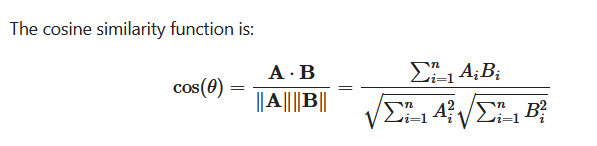

The cosine distance is 1- cosine_simmilarity measure.

In [51]:
def cosine_dist(x, y): 
    dot = np.dot(x, y)
    n1 = np.sqrt(np.dot(x,x))
    n2 = np.sqrt(np.dot(y,y))
    return 1 - dot/(n1*n2)

In [52]:
def get_centroid(related_words_1, H):
    total_dist = 0
    for i, word in enumerate(related_words_1):
        total_dist += H[:,[vocab[word]]]
    return (total_dist/(i + 1)).reshape(10)


In [69]:
count_based = cosine_dist(get_centroid(related_words_1,H),H[:,vocab['America']])
pspmi_based = cosine_dist(get_centroid(related_words_1,H2),H2[:,vocab['America']])


In [70]:
print(f'The count base cosine distance is: {count_based} and the PSPMI base distance is {pspmi_based}.' )


The count base cosine distance is: 0.010341412244003756 and the PSPMI base distance is 0.05864189602374781.


The preformence of both methods are very simmilar. The count based method is sightly better. 

## Problem 3: Word2Vec SkipGram Model (13 points)

Recall that neural models can be used to generate word embeddings instead of using matrix factorization approaches. For this course we have studied Word2vec that was introduced by Mikolov et al., 2013.

**Problem 3.1** (2 points) Recall that Word2Vec has two formulations: CBOW and SkipGram. Read the hyperlinked paper from Mikolov et al., 2013 and summarize the key difference between the two formulations (max 100 words).

* https://arxiv.org/pdf/1301.3781.pdf

1. CBOW predicts the current word using their surrounding. So the input in COBOW is word surrounding while the output is the word. Now the SkipGram works opposite, which means that based on word it tries to predict the word surrounding. 

2. The SkipGram model is more time consuming to perform then CBOW model. 

**Problem 3.2** (7 points) Create a PyTorch implentation of the Skipgram model and train the model with noise contrastive estimation. Let the `forward` method of your model have the following parameters `input_token` and `output_token` and `negative_tokens` that returns the noise contrastive loss of the output word for the given input. 

* Use a hidden dimension of 25, Adam optimizer with learning rate 0.01.
* Train for 10 epochs on the `processed_instances`. To speed up training, use a random sample of 10000 instances each epoch.
* For simplicity sample **one** word from the context for each iteration of training **uniformly at random**. 
* Sample `20` negative instances for noise contrastive estimation uniformly at random from the vocabulary.
* Report the average loss for each epoch


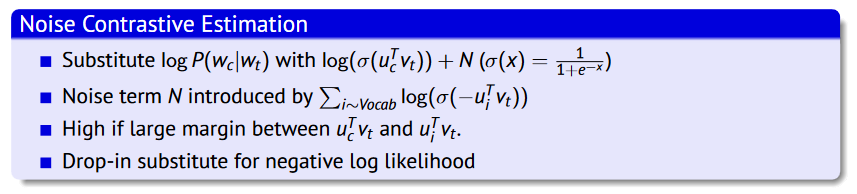

In [55]:
def get_sample(vocab, n):
    sample = []
    for i in range(n):
        selected = random.choice(list(vocab.items()))[1]
        sample.append(torch.LongTensor([selected]))
    return torch.LongTensor(sample)

In [71]:
from torch import nn
import random

negative_samples = 20
emb_size = 25  
vocab_size = len(vocab)

class Skipgram_model(torch.nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        #U (output) and V (input)
        self.output = torch.nn.Embedding(vocab_size,emb_size) 
        self.input = torch.nn.Embedding(vocab_size, emb_size)
        
        
    def forward(self, input_token, output_token, negative_tokens):

        embed_v = self.input(input_token)
        embed_u = self.output(output_token)
        
        score  = torch.mul(embed_u, embed_v)

        score = torch.sum(score, dim=1)

        log_target = torch.nn.functional.logsigmoid(score)

        neg_input_v = self.input(negative_tokens)
        
        neg_score = torch.matmul(neg_input_v,torch.reshape(embed_v,(25,1)))

        neg_score = torch.sum(neg_score, dim=0)

        
        sum_log_sampled = torch.nn.functional.logsigmoid(-1*neg_score)

        
        loss = log_target + sum_log_sampled

        return -1*loss.sum()





In [72]:
from tqdm import tqdm
model = Skipgram_model(vocab_size,emb_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
runloss = 0
for epoch in range(10):
    begginig = np.random.randint(0,len(processed_instances)-10000,1)[0]
    end = begginig + 10000
    for x, data in tqdm(enumerate(processed_instances[begginig:end])):
        word, context_word = data
        # index of the vocabulary
        input_token = torch.LongTensor([vocab[word]])
        # index for random word from context
        index = np.random.randint(0,len(context_word),1)[0]
        output_token = torch.LongTensor([vocab[context_word[index]]])
        
        #input_token, output_token, negative_tokens
        negative_tokens = get_sample(vocab, 20)
        
        
        loss = model(input_token,output_token,negative_tokens)
#         print(f'Loss: {loss}')
        loss.backward()
        optimizer.step()

        # print statistics
        runloss += loss.item()
    print(f'[{epoch + 1}, {x + 1:5d}] loss: {runloss / (x+1):.3f}')
        
    

10000it [04:38, 35.91it/s]


[1, 10000] loss: 11426.298


10000it [04:38, 35.89it/s]


[2, 10000] loss: 65052.988


10000it [04:39, 35.74it/s]


[3, 10000] loss: 176127.017


10000it [04:53, 34.10it/s]


[4, 10000] loss: 361133.473


10000it [04:59, 33.36it/s]


[5, 10000] loss: 639232.263


10000it [04:23, 38.00it/s]


[6, 10000] loss: 1029920.055


10000it [04:53, 34.08it/s]


[7, 10000] loss: 1545242.956


10000it [04:40, 35.67it/s]


[8, 10000] loss: 2162246.813


10000it [04:54, 33.97it/s]


[9, 10000] loss: 2974446.209


10000it [04:48, 34.66it/s]

[10, 10000] loss: 3883708.907


Unfortunatelly, I know that there is probably something wrong with this implementation. Its seems some minus is wrong with loss implementation because the loss is increasing with each epoch. I was trying to fix this but during this process I got problem with NaN values in loss function. If you could show me proper implementation after the assignment is over I would be very glad or find the bug. 

**Problem 3.3** (3 points) subsampling of frequent words is shown to improve performance and speed up training (Mikolov et al., 2013b) (https://arxiv.org/pdf/1310.4546.pdf). 

Instances for a word $w$ are discarded with the following probability $P(w) = 1 - \sqrt{\frac{t}{f(w)}}$.

Implement subsampling of frequent words. Create a copy of the `processed_instances` list from problem 1.3 and call this `subsampled_instances`. Discard instances from this list using the frequency of the input word. Determine an appropriate sampling temperature $t$ by selecting a value that retains approximately $10\%$ of the data.




In [73]:
t = 1.25 #**(-1)
subsampled_instances = []

for data in tqdm(processed_instances):
    word, context = data
    p_w = 1 - np.sqrt((t/tokens_counted[word]))
#     print(p_w)
    if(p_w<0.9):
        subsampled_instances.append(data)
    
    
    

100%|████████████████████████████████████████████████████████████████████| 3780225/3780225 [00:06<00:00, 623091.66it/s]


In [74]:
print(len(subsampled_instances)/len(processed_instances))

0.10411814111593887


**Problem 3.4** (1 point) re-train your model from problem 3.2 using the subsampled instances from problem 3.3. How does the loss of this model trained on the subsample of instances compare to the loss of the model trained on all instances? Suggest why this is this the case. 

In [76]:
from tqdm import tqdm
model = Skipgram_model(vocab_size,emb_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
runloss = 0
for epoch in range(10):
    begginig = np.random.randint(0,len(subsampled_instances)-10000,1)[0]
    end = begginig + 10000
    for x, data in tqdm(enumerate(subsampled_instances[begginig:end])):
        word, context_word = data
        # index of the vocabulary
        input_token = torch.LongTensor([vocab[word]])
        
        # index for random word from context
        index = np.random.randint(0,len(context_word),1)[0]
        output_token = torch.LongTensor([vocab[context_word[index]]])
        
        # input_token, output_token, negative_tokens
        negative_tokens = get_sample(vocab, 20)
        
        
        loss = model(input_token,output_token,negative_tokens)
        loss.backward()
        optimizer.step()

        # print statistics
        runloss += loss.item()
    print(f'[{epoch + 1}, {x + 1:5d}] loss: {runloss / (x+1):.3f}')
        

10000it [05:02, 33.11it/s]


[1, 10000] loss: 17128.681


10000it [04:58, 33.53it/s]


[2, 10000] loss: 104968.671


10000it [04:49, 34.58it/s]


[3, 10000] loss: 306522.787


10000it [04:50, 34.48it/s]


[4, 10000] loss: 662712.873


10000it [04:35, 36.29it/s]


[5, 10000] loss: 1197858.125


10000it [04:00, 41.59it/s]


[6, 10000] loss: 1936262.073


10000it [04:35, 36.34it/s]


[7, 10000] loss: 2918811.111


10000it [04:52, 34.22it/s]


[8, 10000] loss: 4151581.539


10000it [04:55, 33.84it/s]


[9, 10000] loss: 5699793.566


10000it [04:45, 35.08it/s]

[10, 10000] loss: 7591041.882


The loss is coverging quicker. This method allows us to remove more frequent words such as "in", "the" ect. (less valued tokens). So our network is not working the connections between "the" and any random word from vocabulary. We are limitting vaocabulary from "noise". 

## Problem 4: Hierarchical Softmax (5 points)
In Mikolov et al., 2013b (https://arxiv.org/pdf/1310.4546.pdf), Hierarchical softmax estimates the probability of a token as a sequence of binary choices for traversing a tree (additional explanation has been added to the Week 4 Monday Lecture VOD and Slides) given by eqn 3 in the paper. 

It is illustrated for the CBOW model below:

![hs.png](hs.png)

**Problem 4.1** (2 points) In eqn 3 in Mikolov 2013b, the probability for a word is estimated with the Hierarchical Softmax function. The probability of a word is estimated as a the product of binary (left or right) deicsions traversing this tree. Using the definition of the special function in the paper ($\lbrack\lbrack x \rbrack\rbrack$), show that if $p(w,left) = \sigma(u_{n(w,j)}^Tu_l)$, then $p(w,right) = \sigma(- u_{n(w,j)}^Tu_l)$ where $\sigma$ is sigmoid function.

If the probability of a wrod is estimated based on the below equasion:
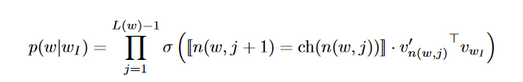

Then considering the binary decision tree and the $\lbrack\lbrack x \rbrack\rbrack$ function with value 1 if true and -1 if not. Then for two different paths (left and right) in a binary tree from the equasion abow we will estimate 1 for one path and oposite values for the second path in one node. This will result in the minus sing before the $u_{n(w,j)}^Tu_l$ multiplication. 

**Problem 4.2** (1 points) Assuming that a balanced binary tree is used to represent a given vocabulary $\mathcal{V}$. What is the expected number of hops required to reach each leaf node (give your answer in terms of $|\mathcal{V}|$).

If the tree is balanced that meens the height of the left and right subtree of any node differ by not more than 1. As I understand the  $|\mathcal{V}|$ is leght of the vocabulary which is the number of words at the bootom of the tree. So the expected numebr of hops required to reach each bottom node is  $\frac{|\mathcal{V}|}{2}$ rounded up. 

**Problem 4.3** (2 points) Compare the runtime efficiency of Softmax, Noise Contrastive Estimation, and Hierarchical Softmax. Why is it prefereable to use these alternatives to Softmax when computing loss? (max 100 words)

Softmax needs to evaluate $\mathcal{W}$ output nodes while hierarchical sfotmax needs only $log{_2}{W}$ nodes. And the Noise Contrastive Estimation avoids calculation of the partition function or its derivatives at each training step.

Softmax can be slow to train and output large layers. That's why there is a lot of alternative for softmax espacially concerning the NLP models which usually requires large vocabularies. 